In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
i=0
def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 
def deprocess_img(x):
    return (x + 1.0) / 2.0

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



469
(128, 784)


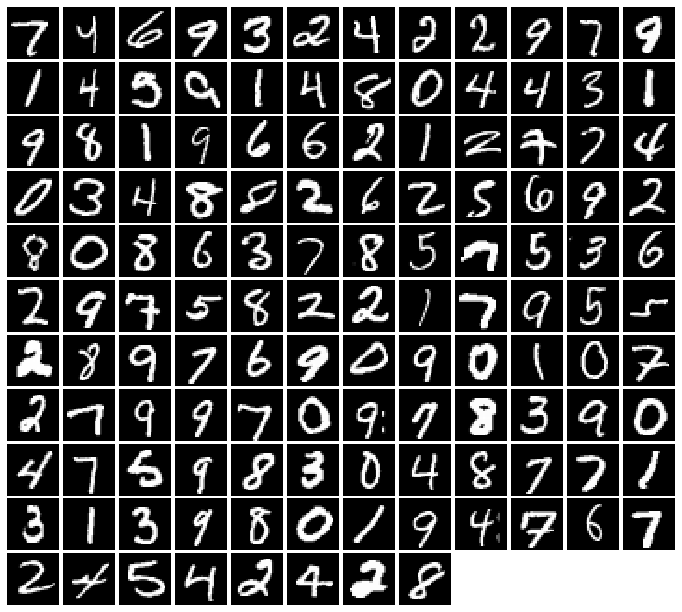

In [2]:
#数据处理
im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5]) # 标准化
])
train_set = MNIST('./mnist',download=True, transform=im_tfs)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)
i=0
for x,_ in train_data:
  i+=1
print(i)

imgs = deprocess_img(train_data.__iter__().next()[0].view(128, 784)).numpy().squeeze() # 可视化图片效果
print(imgs.shape)
show_images(imgs)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [5]:
#定义编码器
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var

    def encode(self, x): #编码层
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() #e**(x/2)
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return z,KLD # 解码，同时输出均值方差

In [6]:
NOISE_DIM=20
bs=128

In [7]:
class Decoder(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),#128,64,3,3
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),#128,1,1,1
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),#24,24
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),#12,12
            nn.Conv2d(32, 64, 5, 1),#8,8
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)#4,4
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.f=nn.Sequential(
            nn.Conv2d(64,1,4,2,1),
            nn.AvgPool2d(2)
        )#1,1
        
    def forward(self, x):
        x = self.conv(x)
        f=self.f(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x,f.squeeze()

In [9]:
Gen=Decoder().cuda()
Dis=Discriminator().cuda()
sample_noise = (torch.rand(128, 20) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
g_fake_seed = Variable(sample_noise).cuda()
fake_images = Gen(g_fake_seed) # 生成的假的数据
print(fake_images.shape)
logits_fake,_ = Dis(fake_images) # 判别网络得分
print(logits_fake.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])


In [10]:
Enc=Encoder().cuda()
fake_images=fake_images.view(128,-1)
print(fake_images.shape)
z,kld=Enc(fake_images)
print(z.shape)


torch.Size([128, 784])
torch.Size([128, 20])


In [11]:
print(torch.cuda.is_available())
Enc=Encoder().cuda()
Gen=Decoder().cuda()
D=Discriminator().cuda()
E_trainer = torch.optim.Adam(Enc.parameters(), lr=1e-3)
G_trainer = torch.optim.Adam(Gen.parameters(), lr=3e-4, betas=(0.5, 0.999))
D_trainer = torch.optim.Adam(D.parameters(), lr=3e-4, betas=(0.5, 0.999))

True


In [12]:
def lossD(scores_real, scores_fake0,scores_fake1):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake0 ** 2).mean()+0.5 * (scores_fake1 ** 2).mean()
    return loss

def lossGD(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()
    return loss

In [16]:
def training(epochs=20):
    for epoch in range(epochs):
        T_loss_D = []
        T_loss_G = []
        T_loss_GD = []
        T_loss_kld = []
        i=0
        for x_r,_ in train_data:
            i+=1
            if i==469:
              break
            x_r=x_r.cuda()
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p = D(x_p)
            
            #---------------------D training --------------------------------
            loss_D=lossD(ld_r,ld_p,ld_f)
            D_trainer.zero_grad()
            loss_D.backward()
            D_trainer.step() 

            #------------------------G & E  training------------------
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p= D(x_p)
            loss_GD=lossGD(ld_p)
            loss_G = 0.5 * (0.01*(x_f - x_r).pow(2).sum() + (fd_f - fd_r.pow(2).sum())) / bs   
            G_trainer.zero_grad()
            E_trainer.zero_grad()
            kld.backward(retain_graph=True)
            (0.01*loss_G+loss_GD).backward(torch.ones_like(loss_G))
            G_trainer.step()
            E_trainer.step()
        imgs_numpy = deprocess_img(x_p.data.cpu().numpy())
        print("epoch:", epoch)
        show_images(imgs_numpy[0:16])


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19


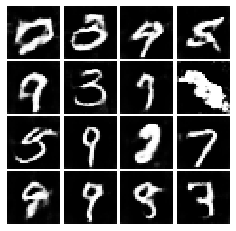

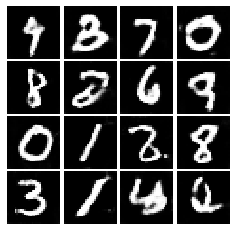

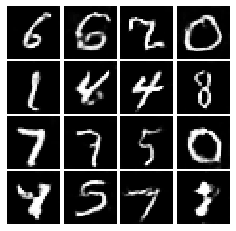

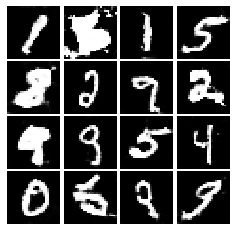

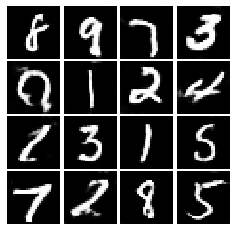

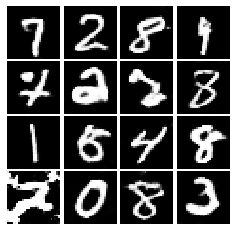

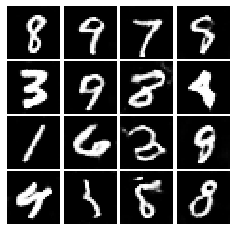

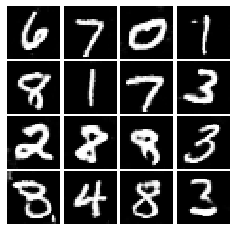

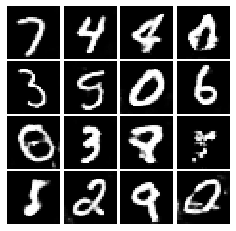

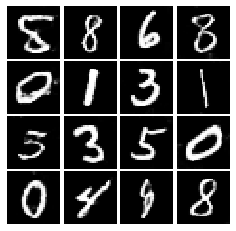

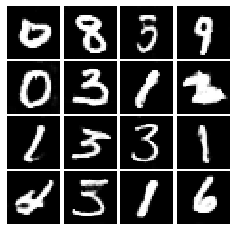

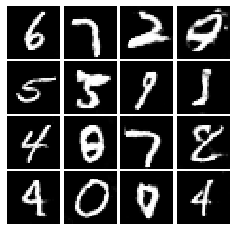

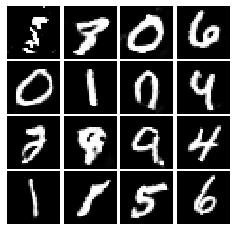

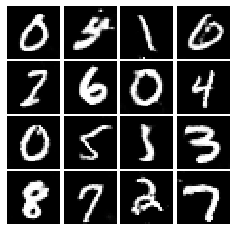

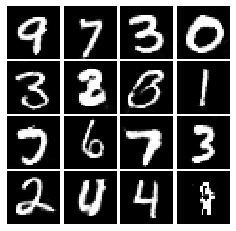

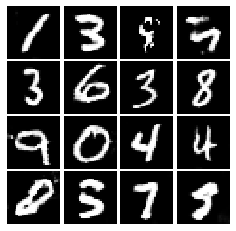

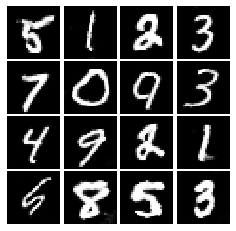

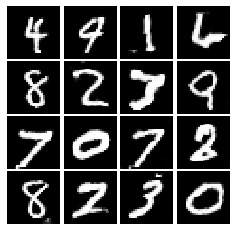

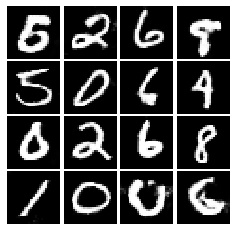

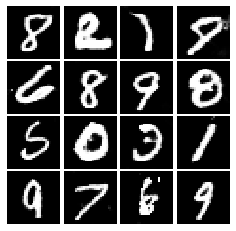

In [17]:
training()

In [18]:
sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
g_fake_seed = Variable(sample_noise).cu
x_p = Gen(g_fake_seed)
imgs_numpy = deprocess_img(x_p.data.cpu().numpy())
show_images(imgs_numpy)

RuntimeError: ignored